# Parallel Processing of Wine Review Data**

## Objective

Can we recreate this $5$ basic wine type groupings?

<p align="center">
<img src="images/Different-Types-of-Wine-v2.jpg"alt="wine types" width="300"><img>
</p>

## Define Wine Classifications

**Helper functions to classify wines into the $9$ basic styles and $5$ basic types**

In [15]:
from collections import namedtuple
import pandas as pd

WINE_STYLE = namedtuple('WINE_STYLE', ['name', 'varieties'])

# wine varieties by wine style
sparkling = WINE_STYLE('sparkling', ['Cava','Prosecco', 'Crémant','Champagne', 'Spumante', 'Sparkling Blend'])

light_white = WINE_STYLE('light_white',
                         ['Albariño','Aligoté','Assyrtiko','Chablis','Chasselas','Chenin Blanc','Cortese','Friulano','Sauvignon Vert','Garganega','Grenache Blanc','Muscadet','Melon','Picpoul de Pinet','Pinot Blanc','Pinot Grigio','Pinot Gris','Verdejo','Verdicchio','Xarel-lo',]\
                          + ['Erbaluce','Grüner Veltliner','Sancerre','Sauvignon Blanc','Vermentino','Vinho Verde']
                        )
full_white = WINE_STYLE('full_white', ['Chardonnay','Marsanna','Sémillon','Trebbiano','Viognier','White Rioja','Pecorino', 'White Blend'])
aromatic_white = WINE_STYLE('aromatic_white', ['Gewürztraminer','Müller-Thurgau','Moschofilero','Muscat','Muscat Blanc','Moscato','Riesling','Torrontés',])
rose = WINE_STYLE('rose', ['Rosé', 'Rose'])
light_red = WINE_STYLE('light_red', ['Schiava', 'Gamay', 'Pinot Noir','Counoise', 'St. Laurent','Cinsaut','Primitivo','Blaufränkisch','Barolo'])
medium_red = WINE_STYLE('medium_red', ['Grenache','Granacha','Valpolicella Blend','Bobal','Carménère','Carignan','Cabernet Franc','Mencía', 'Sangiovese','Negroamaro','Rhône-style Red Blend', 'Rhône/GSM Blend','Barbera','Merlot','Montepulciano','Zinfandel','Marquette','Chambourcin','Petite Pearl','Red Blend', 'Portuguese Red'])
full_red = WINE_STYLE('full_red', ['Tempranillo','Nebbiolo',"Nero d'Avola",'Aglianico','Malbec','Bordeaux Blend','Cabernet Sauvignon','Syrah','Shiraz','Priorat','Touriga Franca','Pinotage','Petit Verdot','Mourvèdre','Touriga Nacional','Petite Sirah','Sagrantino','Tannat','Bordeaux-style Red Blend'])
dessert = WINE_STYLE('dessert', ['Ice Wine','Late Harvest','Madeira','Malvasia','Sauternes','Sherry','Tokaji','Vin Santo','White Port','Port','Porto','Marsala','Noble Rot','Passito','Freisa'])

all_varieties = pd.Series(sparkling.varieties + light_white.varieties + full_white.varieties + aromatic_white.varieties + rose.varieties + light_red.varieties + medium_red.varieties + full_red.varieties + dessert.varieties)

# assign style
styles = [sparkling, light_white, full_white, aromatic_white, rose, light_red, medium_red, full_red, dessert]
to_style = lambda wine: next(map(lambda style: style.name, filter(lambda style: wine in style.varieties, styles)))
to_type = lambda wine: next(map(lambda style: style.name.split('_')[-1], filter(lambda style: wine in style.varieties, styles)))


**Verify that there are no repeated wines varieties in the styles**

In [16]:
# verify there are no variety duplicated in any of the style varietals
assert all_varieties[all_varieties.duplicated()].count() == 0

**Verify the Type & Style Helpers**

In [17]:
assert to_style('Pinot Noir') == 'light_red'
assert to_type('Pinot Noir') == 'red'
to_style('Pinot Noir'), to_type('Pinot Noir')

('light_red', 'red')

## Load Preprocessed Reviews

Libraries

In [18]:
import numpy as np
import time

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [19]:
df = pd.read_parquet('data/wine/wine_review.parquet.gzip', columns=['title', 'description', 'variety', 'country', 'location', 'wine_style', 'type', 'classification'])
df.info()
df


<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   title           100538 non-null  object
 1   description     100538 non-null  object
 2   variety         100538 non-null  object
 3   country         100538 non-null  object
 4   location        100538 non-null  object
 5   wine_style      100538 non-null  object
 6   type            100538 non-null  object
 7   classification  100538 non-null  object
dtypes: object(8)
memory usage: 6.9+ MB


,title,description,variety,country,location,wine_style,type,classification
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Etna,light_white,white,Old World
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Douro,medium_red,red,Old World
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Oregon,light_white,white,New World
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,Michigan,aromatic_white,white,New World
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Oregon,light_red,red,New World
...,...,...,...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Notes of honeysuckle and cantaloupe sweeten th...,Riesling,Germany,Mosel,aromatic_white,white,Old World
129967,Citation 2004 Pinot Noir (Oregon),Citation is given as much as a decade of bottl...,Pinot Noir,US,Oregon,light_red,red,New World
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Well-drained gravel soil gives this wine its c...,Gewürztraminer,France,Alsace,aromatic_white,white,Old World
129969,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),"A dry style of Pinot Gris, this is crisp with ...",Pinot Gris,France,Alsace,light_white,white,Old World


## Feature Extraction

### Vectorize

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords

swords = list(set(['wine', '100', '2016', '2017', '2018', '2019', '2020', 'also', 'made', 'make', 'like', 'drink', 'drinking', 'yet', 'year', 'years'] + stopwords.words('english')))

vectorizer = TfidfVectorizer(max_features=2**12, stop_words=swords, min_df=.015, max_df=.95)
tf_v = vectorizer.fit_transform(df.description)
tf_v.shape

(100538, 321)

**Inspect Features**

In [50]:
vectorizer.get_feature_names_out()

array(['acidity', 'acids', 'aftertaste', 'age', 'aged', 'aging',
       'alcohol', 'almond', 'almost', 'along', 'alongside', 'already',
       'although', 'anise', 'apple', 'apricot', 'aromas', 'aromatic',
       'around', 'attractive', 'baked', 'baking', 'balance', 'balanced',
       'barrel', 'berries', 'berry', 'best', 'big', 'bit', 'bitter',
       'black', 'blackberries', 'blackberry', 'blanc', 'blend',
       'blueberry', 'bodied', 'body', 'bold', 'bottle', 'bottling',
       'bouquet', 'bright', 'brings', 'brisk', 'cabernet', 'candied',
       'caramel', 'cassis', 'cedar', 'character', 'chardonnay',
       'cherries', 'cherry', 'chewy', 'chocolate', 'cinnamon', 'citrus',
       'clean', 'close', 'clove', 'coffee', 'cola', 'color', 'come',
       'comes', 'complex', 'complexity', 'concentrated', 'concentration',
       'cool', 'core', 'could', 'cranberry', 'creamy', 'crisp', 'crushed',
       'currant', 'currants', 'cut', 'dark', 'deep', 'delicate',
       'delicious', 'delivers'

**Drop Number Features**

In [51]:
features = np.array(list(filter(lambda col: col[:1].isalpha(), vectorizer.get_feature_names_out())))
features[:50]

array(['acidity', 'acids', 'aftertaste', 'age', 'aged', 'aging',
       'alcohol', 'almond', 'almost', 'along', 'alongside', 'already',
       'although', 'anise', 'apple', 'apricot', 'aromas', 'aromatic',
       'around', 'attractive', 'baked', 'baking', 'balance', 'balanced',
       'barrel', 'berries', 'berry', 'best', 'big', 'bit', 'bitter',
       'black', 'blackberries', 'blackberry', 'blanc', 'blend',
       'blueberry', 'bodied', 'body', 'bold', 'bottle', 'bottling',
       'bouquet', 'bright', 'brings', 'brisk', 'cabernet', 'candied',
       'caramel', 'cassis'], dtype='<U13')

In [52]:
# load tf-idf
tfidf = pd.read_parquet('data/wine/wine_review-tfidf.parquet.gzip')
tfidf.head()

,accent,accessible,accompany,acid,acidic,acidity,acre,add,addition,additional,...,wrap,year,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
0,0.0,0.0,0.0,0.0,0.0,0.136429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.154443,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.128762,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Matrix

In [ ]:
X = tfidf
X

,accent,accessible,accompany,acid,acidic,acidity,acre,add,addition,additional,...,wrap,year,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
0,0.0,0.0,0.0,0.0,0.0,0.136429,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.154443,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.128762,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0.0,0.0,0.0,0.0,0.0,0.141924,0.0,0.0,0.0,0.0,...,0.329377,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129967,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129968,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.221678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129969,0.0,0.0,0.0,0.0,0.0,0.151077,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualize the Extracted Features

See [Visualizing TF-IDF Scores: A Comprehensive Guide to Plotting a Document TF-IDF 2D Graph](https://www.geeksforgeeks.org/visualizing-tf-idf-scores-a-comprehensive-guide-to-plotting-a-document-tf-idf-2d-graph/) for reference.

In [ ]:
# start with a subset of the data to see how long the operation will take
n_samples = 5_000
s = X if n_samples is None else X.sample(n_samples, random_state=42)
s.head()

,accent,accessible,accompany,acid,acidic,acidity,acre,add,addition,additional,...,wrap,year,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
12616,0.000000,0.0,0.0,0.237188,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49741,0.174744,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.14095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35244,0.000000,0.0,0.0,0.000000,0.0,0.118636,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52642,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83201,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Dimension Reduction

Since the TF-IDF vectors have $4,076$ dimensions (unique words), we need to reduce the dimensionality to 2D for visualization. We can use either PCA or t-SNE to project our data into a 2D or 3D space that can be easily plotted

**PCA Dimensional Reduction**

In [ ]:
from sklearn.decomposition import PCA

start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_result[:10]

It took 0 seconds to process 5,000 samples with 942 features. It will take 0 minutes to process the entire data set.

array([[ 0.02667509,  0.07246243],
       [-0.07832869, -0.01369817],
       [-0.10093353, -0.10673104],
       [ 0.11631185,  0.1685598 ],
       [-0.06133597,  0.07436754],
       [ 0.06694993, -0.19160803],
       [ 0.18001734,  0.05684584],
       [-0.03789465,  0.04216313],
       [-0.03960734, -0.06305898],
       [-0.07315785,  0.05099404]])

**t-SNE Dimensional Reduction**

In [ ]:
from sklearn.manifold import TSNE

start = time.perf_counter()
tsne = TSNE(random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
tsne_result[:10]

It took 9 seconds to process 5,000 samples with 942 features. It will take 3 minutes to process the entire data set.

array([[ 96.73279 ,  -9.932688],
       [ 16.96736 , -13.872489],
       [-75.0933  ,  30.869513],
       [ 25.276556,  53.685722],
       [-10.705565,  22.886305],
       [ 37.604584, -49.499226],
       [ 97.17034 , -14.019504],
       [ 13.070119,  31.002785],
       [ 52.14875 ,  22.558247],
       [-64.52661 , -18.795338]], dtype=float32)

**t-SNE with PCA Dimensional Reduction**

Use PCA to pre-reduce the dimensions before fitting with t-SNE.

In [ ]:
start = time.perf_counter()
pca_tsne = TSNE(random_state=42, perplexity=10)
pca_tsne_result = pca_tsne.fit_transform(PCA(50, random_state=42).fit_transform(s.to_numpy()))
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_tsne_result[:10]

It took 11 seconds to process 5,000 samples with 942 features. It will take 4 minutes to process the entire data set.

array([[ 39.11178  ,  24.168674 ],
       [-45.737713 ,  17.775604 ],
       [-14.129839 , -76.01918  ],
       [ 66.173004 ,  33.886097 ],
       [-41.71628  ,  32.899807 ],
       [ 25.477514 , -47.629894 ],
       [ 52.625713 ,  21.620295 ],
       [  1.5266998,  49.956753 ],
       [ -2.1004996,  56.229847 ],
       [-60.865303 ,   7.4379215]], dtype=float32)

#### Visualizing the TF-IDF Vectorization Results

**Plot the Result**

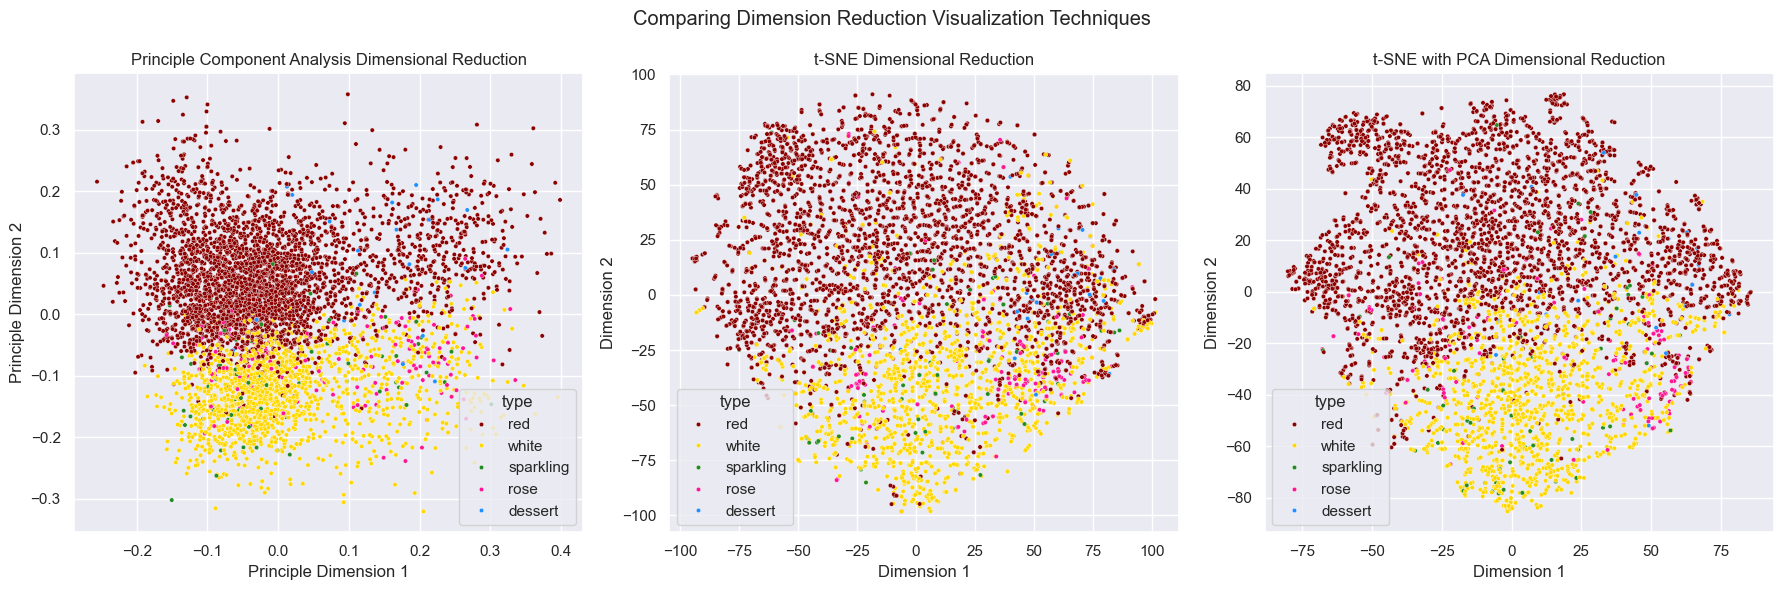

In [ ]:
color_map = dict(
  sparkling='forestgreen',
  white='gold',
  rose='deeppink',
  red='darkred',
  dessert='dodgerblue',
)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df.loc[s.index].type, ax=ax[0], s=10, palette=color_map)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[1], s=10, palette=color_map)
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[2], s=10, palette=color_map)
plt.suptitle('Comparing Dimension Reduction Visualization Techniques')
ax[0].set_xlabel('Principle Dimension 1')
ax[0].set_ylabel('Principle Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[0].set_title('Principle Component Analysis Dimensional Reduction')
ax[1].set_title('t-SNE Dimensional Reduction')
ax[2].set_title('t-SNE with PCA Dimensional Reduction')
plt.tight_layout()
plt.show()



**Observation**: The dimensional reduction clearly shows there is some structure to the data

## Cluster Analysis

### KMeans Clustering

see [Clustering documents with TFIDF and KMeans](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans)

**Pick number of clusters for KMeans**

In [ ]:
n_clusters = [len(df.classification.unique()),len(df.type.unique()),len(df.wine_style.unique()),20, 35, len(df.variety.unique())]
n_clusters

[2, 5, 9, 20, 35, 50]

**MiniBatchKMeans**

Using MiniBatchKMeans since there are well over 10k samples.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# sum of squared error vs k
models = [MiniBatchKMeans(n_clusters=n, init_size=1024, batch_size=2048, max_iter=100, random_state=42).fit(X) for n in n_clusters]
models

[MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=2, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=5, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=9, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=20, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=35, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=50, random_state=42)]

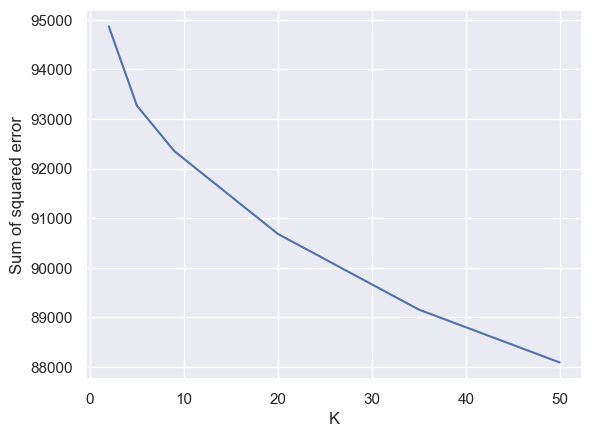

In [ ]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(n_clusters,[model.inertia_ for model in models])

**Predict the Wine Cluster Based on Review**

In [ ]:
df['predicted_classification'] = models[0].predict(X)
df['predicted_type'] = models[1].predict(X)
df['predicted_wine_style'] = models[2].predict(X)
df['predicted_variety'] = models[5].predict(X)

df.head()

,title,description,variety,country,location,wine_style,type,classification,predicted_classification,predicted_type,predicted_wine_style,predicted_variety
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Etna,light_white,white,Old World,0,1,1,38
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Douro,medium_red,red,Old World,1,3,8,14
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Oregon,light_white,white,New World,1,1,1,6
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,Michigan,aromatic_white,white,New World,0,1,1,35
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Oregon,light_red,red,New World,0,0,4,22


**Visualize Clusters**

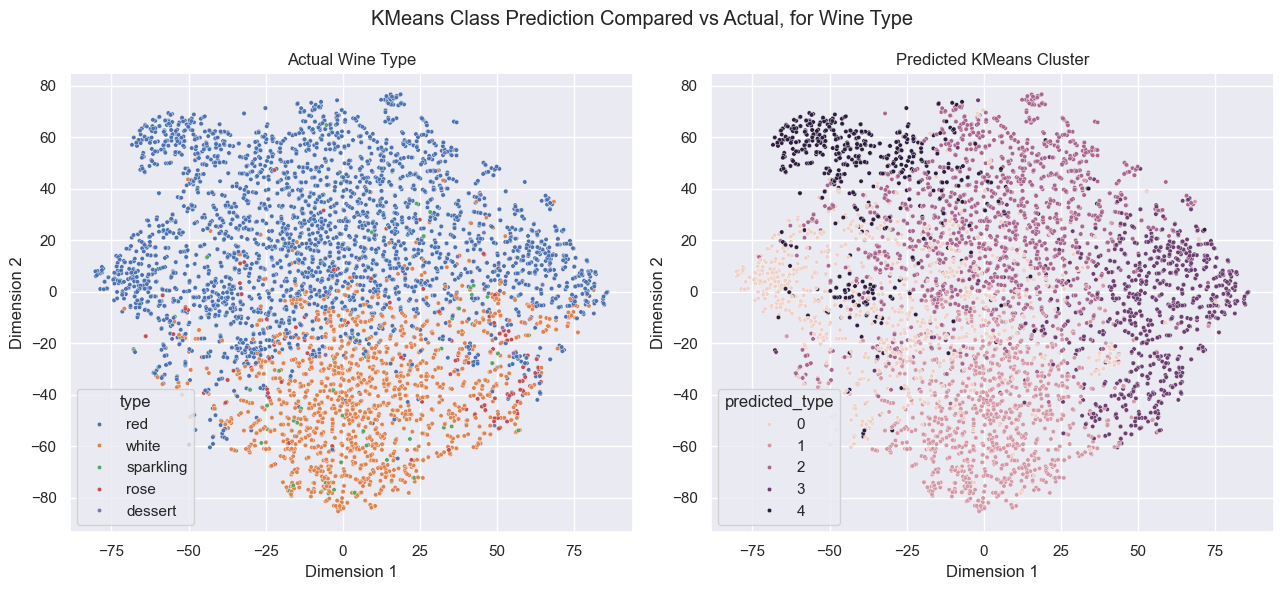

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[0], s=10)
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].predicted_type, ax=ax[1], s=10)
plt.suptitle('KMeans Class Prediction Compared vs Actual, for Wine Type')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[0].set_title('Actual Wine Type')
ax[1].set_title('Predicted KMeans Cluster')
plt.tight_layout()
plt.show()

### Agglomerative Clustering

 - [Mastering Text Clustering with Python: A Comprehensive Guide](https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327) Intro to agglomerative clustering
 - [Cosine Similarity and Hierarchical Clustering](https://rafamarino.com/posts/tfidf/#similarity-score--cosine-similarity)
 - [Mastering Hierarchical Clustering : From Basic to Advanced](https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93)
 - [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [96]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Hierarchical Clustering
# agglo = AgglomerativeClustering(n_clusters=None, metric='cosine', distance_threshold=0, linkage='average', compute_distances=True).fit(PCA(50, random_state=42).fit_transform(s))
agglo = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(PCA(5, random_state=42).fit_transform(s))
agglo

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

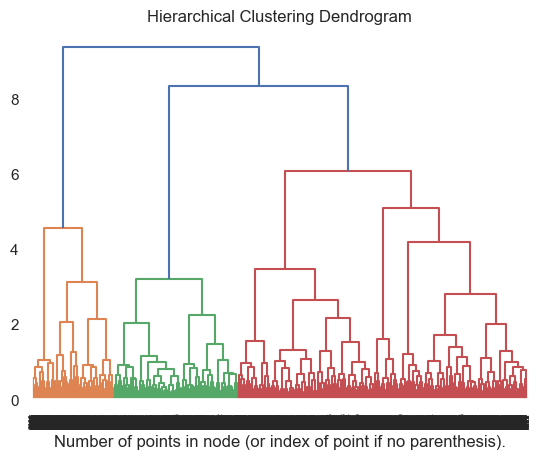

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Further Work

- Evaluate [silhouette](https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a) scores for clusters.

In [89]:
swords = list(set(['wine', 'also', 'made', 'make', 'like', 'drink', 'drinking', 'yet', 'year', 'years', 'variety'] + stopwords.words('english')))

vectorizer = TfidfVectorizer(max_features=2**12, stop_words=swords, min_df=.01, max_df=.95)
x = vectorizer.fit_transform(df.description)
X = pd.concat([df.variety, pd.DataFrame(x.toarray(), index=df.index, columns=vectorizer.get_feature_names_out())], axis=1)
X.drop(list(filter(lambda col: not col[:1].isalpha(), vectorizer.get_feature_names_out())), axis=1, inplace=True)
print(X.shape)
X.head()

(100538, 425)


,variety,accented,accents,acidic,acidity,acids,add,adds,aftertaste,age,...,wild,winery,wines,without,wood,would,yellow,young,zest,zesty
0,White Blend,0.0,0.0,0.0,0.152599,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Portuguese Red,0.0,0.0,0.0,0.152597,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pinot Gris,0.0,0.0,0.0,0.208380,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Riesling,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pinot Noir,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
tfidf_by_variety = X.groupby('variety').mean()
tfidf_by_variety

,accented,accents,acidic,acidity,acids,add,adds,aftertaste,age,aged,...,wild,winery,wines,without,wood,would,yellow,young,zest,zesty
variety,,,,,,,,,,,,,,,,,,,,,
Aglianico,0.008932,0.000954,0.000000,0.012594,0.000000,0.004913,0.001479,0.000638,0.006508,0.011743,...,0.016002,0.001591,0.009525,0.001949,0.007305,0.009274,0.000000,0.006208,0.002101,0.003315
Albariño,0.000000,0.003585,0.013176,0.046957,0.005293,0.000000,0.001456,0.000613,0.003093,0.007905,...,0.002261,0.003798,0.006195,0.007963,0.003690,0.001971,0.007667,0.001940,0.002175,0.015265
Barbera,0.003237,0.005729,0.007735,0.052646,0.004101,0.005269,0.003721,0.001007,0.004901,0.011545,...,0.016166,0.004505,0.001724,0.004049,0.007103,0.010746,0.000000,0.005913,0.004660,0.003849
Bordeaux-style Red Blend,0.001517,0.002114,0.000965,0.050491,0.003416,0.002817,0.002941,0.012599,0.024831,0.006724,...,0.000967,0.003891,0.006023,0.003987,0.057358,0.001597,0.000115,0.013558,0.000065,0.000205
Bordeaux-style White Blend,0.000677,0.000368,0.000000,0.081479,0.000404,0.004513,0.007954,0.036975,0.020860,0.012436,...,0.000269,0.002662,0.007161,0.003807,0.047969,0.001337,0.027649,0.015186,0.016631,0.004628
Cabernet Franc,0.009080,0.004701,0.002081,0.033684,0.008129,0.009936,0.005620,0.003594,0.010944,0.007700,...,0.005616,0.004617,0.004700,0.002793,0.014235,0.003005,0.000235,0.012644,0.000201,0.002966
Cabernet Sauvignon,0.004976,0.005693,0.002846,0.015847,0.006167,0.004147,0.003636,0.000594,0.012939,0.004905,...,0.003648,0.008689,0.005460,0.003088,0.006656,0.002778,0.000178,0.009616,0.000713,0.001270
Carmenère,0.003451,0.006895,0.012269,0.019272,0.005605,0.001044,0.000558,0.000896,0.000470,0.001153,...,0.009464,0.002237,0.002892,0.001725,0.013440,0.000698,0.000000,0.001370,0.000967,0.003615
Champagne Blend,0.000000,0.000776,0.000000,0.077033,0.000000,0.007036,0.003482,0.020750,0.071505,0.009395,...,0.000000,0.000000,0.012016,0.004373,0.005162,0.005538,0.012854,0.043441,0.012309,0.004349


In [116]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

agglo = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(PCA(5, random_state=42).fit_transform(tfidf_by_variety))
agglo

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

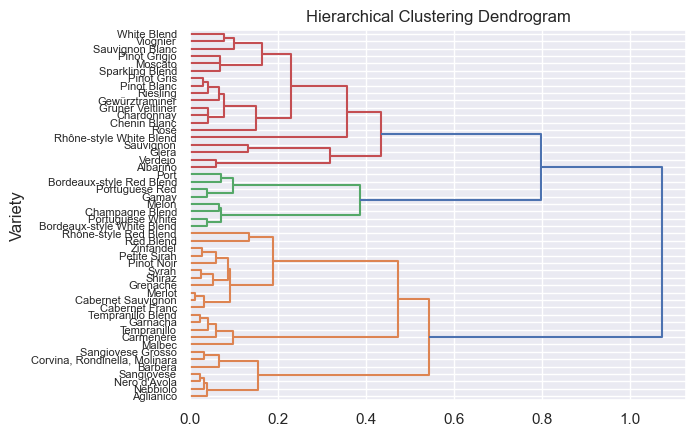

In [117]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, truncate_mode="level", labels=tfidf_by_variety.index, orientation='right')
plt.ylabel("Variety")
plt.show()